In [94]:
import numpy as np
from scipy import stats
from numba import njit
import matplotlib.pyplot as plt
import numba as nb

In [95]:
#####################################################
####### Helper Functions to get the Moments #########
#####################################################
@njit(parallel=True)
def get_moments(inf_timesteps,agent_pdf,time_pdf):
    m1=0.0
    m2=0.0
    for j in nb.prange(len(inf_timesteps)):
        x = inf_timesteps[j]
        px = agent_pdf[j]
        for k in range(len(inf_timesteps)):
            y = inf_timesteps[k]
            py = time_pdf[k]
            if x<y:
                I = 1
            else:
                I = 0 
            m1 += (x**1)*px*py*I
            m2 += (x**2)*px*py*I
    return [m1,m2]

@njit
def get_skew(EX,EX2,EX3,sigma):
    ans = (EX3 - 3*EX*EX2**2 +3*EX**2*EX- EX**3)/(sigma**3)
    return ans

@njit
def get_kurtosis(EX,EX2,EX3,EX4,sigma):
    ans = (EX4 - 4*EX*EX3 + 6*EX**2*sigma**2 + 3*EX**4)/(sigma**4)
    return ans

In [96]:
def prob_making_based_on_agent_v2(regular_timesteps,num_blocks,
                                  agent_means,agent_stds,timing_uncertainty):
    inf_timesteps = np.arange(0,5000,1) # Timesteps need to go from -inf to +inf
    time_means_tiled = np.tile(regular_timesteps,(len(inf_timesteps),1)).T
    # tiled_agent_means = np.tile(agent_means,(len(inf_timesteps),1)).T
    # tiled_agent_stds  = np.tile(agent_stds,(len(inf_timesteps),1)).T

    agent_pdfs = np.zeros((len(inf_timesteps)))
    timing_pdfs = np.zeros((len(regular_timesteps),len(inf_timesteps)))
    # for i in range(num_blocks):
    agent_pdfs = stats.norm.pdf(inf_timesteps,agent_means[1],agent_stds[1])
    timing_pdfs = stats.norm.pdf(inf_timesteps,time_means_tiled,150)
    moments_array = np.empty((2,len(regular_timesteps)))
    print('here')
    for i in range(len(regular_timesteps)):
        prob_x_in_A = stats.norm.cdf(0,agent_means[1]-regular_timesteps[i],np.sqrt(agent_stds[1]**2 + 150**2))
        moments_array[:,i] = get_moments(inf_timesteps,agent_pdfs,timing_pdfs[i])/prob_x_in_A
    return moments_array

In [97]:
timing_uncertainty = np.array([100]*6)
agent_means = np.array([1000,1000,1100,1100,1200,1200])
agent_stds = np.array([50,150,50,150,50,150])
num_blocks = 6
regular_timesteps = np.arange(0,2000,1)

m = prob_making_based_on_agent_v2(regular_timesteps,num_blocks,agent_means,agent_stds,timing_uncertainty)

here


In [104]:
m[0,700]

798.3434195787613

In [98]:
inf_timesteps = np.arange(0,5000,1) # Timesteps need to go from -inf to +inf
old_timesteps = np.arange(0,2000,1)
time_means = np.tile(old_timesteps,(len(inf_timesteps),1)).T

a = stats.norm.pdf(inf_timesteps,time_means,100)

In [99]:
time_means

array([[   0,    0,    0, ...,    0,    0,    0],
       [   1,    1,    1, ...,    1,    1,    1],
       [   2,    2,    2, ...,    2,    2,    2],
       ...,
       [1997, 1997, 1997, ..., 1997, 1997, 1997],
       [1998, 1998, 1998, ..., 1998, 1998, 1998],
       [1999, 1999, 1999, ..., 1999, 1999, 1999]])

In [100]:
a.shape

(2000, 5000)

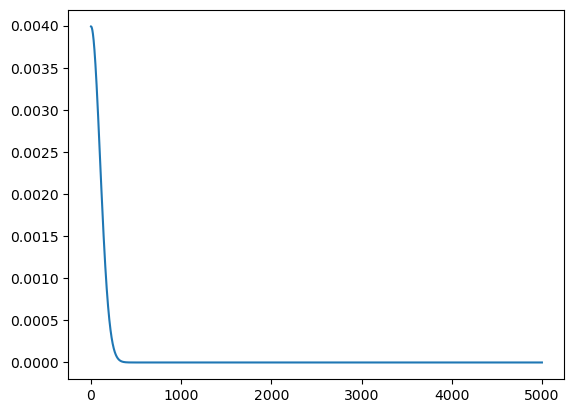

In [101]:
plt.plot(a[0,:])

In [126]:

def mean_of_conditioned_distribution(mu_x, sigma_x, mu_y, sigma_y):
    # Compute the probability that X < Y
    p = stats.norm.cdf((mu_y - mu_x) / ((sigma_x**2 + sigma_y**2)**0.5))
    
    # Set bounds for the new distribution
    lower_bound = 0
    upper_bound = 2000
    
    # Compute the mean of the new distribution, conditioned on X < Y
    new_mu = mu_x + (sigma_x / p) * (stats.norm.pdf((mu_y - mu_x) / ((sigma_x**2 + sigma_y**2)**0.5)) - ((mu_y - mu_x) / ((sigma_x**2 + sigma_y**2)**0.5)) * p * stats.norm.cdf((mu_y - mu_x) / ((sigma_x**2 + sigma_y**2)**0.5)))
    new_mu = min(max(lower_bound, new_mu), upper_bound) # bound the result between 0 and 2000
    
    return new_mu


In [128]:
mu_x = 1000
sigma_x = 150
mu_y = 1001
sigma_y = 150

new_mu = mean_of_conditioned_distribution(mu_x, sigma_x, mu_y, sigma_y)

print(new_mu) # Output: 91.40586389260244

1118.8780064256657
